# Music Classification Inference

This notebook demonstrates how to use trained models for music genre prediction on new audio files.

In [34]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Load Model

In [35]:
def load_trained_model(model_class, model_path, n_classes, device='cpu'):
    """Load a trained model."""
    model = model_class(n_classes=n_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Model loaded from {model_path}")
    return model

## Audio Preprocessing

In [36]:
def preprocess_audio(audio_path, sample_rate=22050, duration=30):
    """Load and preprocess audio file for inference."""
    # Load audio
    waveform, sr = torchaudio.load(audio_path)
    
    # Resample if necessary
    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(sr, sample_rate)
        waveform = resampler(waveform)
    
    # Convert to mono
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    # Pad or truncate to fixed duration
    target_length = sample_rate * duration
    if waveform.shape[1] > target_length:
        waveform = waveform[:, :target_length]
    elif waveform.shape[1] < target_length:
        padding = target_length - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, padding))
    
    # Add batch dimension
    waveform = waveform.unsqueeze(0)
    
    return waveform

## Single File Prediction (Genre Classification)

In [37]:
def predict_genre(model, audio_path, genre_names, device='cpu', sample_rate=22050, duration=30):
    """Predict genre for a single audio file."""
    # Preprocess audio
    waveform = preprocess_audio(audio_path, sample_rate, duration)
    waveform = waveform.to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(waveform)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    predicted_genre = genre_names[predicted.item()]
    confidence_score = confidence.item()
    
    # Get top-k predictions
    top_k = min(5, len(genre_names))
    top_probs, top_indices = torch.topk(probabilities[0], top_k)
    
    print(f"\nPrediction for: {Path(audio_path).name}")
    print(f"Predicted Genre: {predicted_genre}")
    print(f"Confidence: {confidence_score*100:.2f}%")
    print(f"\nTop {top_k} predictions:")
    for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
        print(f"{i+1}. {genre_names[idx.item()]}: {prob.item()*100:.2f}%")
    
    return predicted_genre, confidence_score, probabilities[0].cpu().numpy()

## Multi-label Prediction (Music Tagging)

In [38]:
def predict_tags(model, audio_path, tag_names, device='cpu', sample_rate=22050, 
                 duration=29, threshold=0.5, top_k=10):
    """Predict tags for a single audio file (multi-label)."""
    # Preprocess audio
    waveform = preprocess_audio(audio_path, sample_rate, duration)
    waveform = waveform.to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(waveform)
        probabilities = torch.sigmoid(outputs)
    
    probs = probabilities[0].cpu().numpy()
    
    # Get tags above threshold
    predicted_tags = [(tag_names[i], probs[i]) for i in range(len(tag_names)) 
                      if probs[i] > threshold]
    predicted_tags.sort(key=lambda x: x[1], reverse=True)
    
    # Get top-k tags
    top_tags_indices = np.argsort(probs)[-top_k:][::-1]
    top_tags = [(tag_names[i], probs[i]) for i in top_tags_indices]
    
    print(f"\nPrediction for: {Path(audio_path).name}")
    print(f"\nPredicted tags (threshold={threshold}):")
    if predicted_tags:
        for tag, prob in predicted_tags:
            print(f"  - {tag}: {prob*100:.2f}%")
    else:
        print("  No tags above threshold")
    
    print(f"\nTop {top_k} tags:")
    for i, (tag, prob) in enumerate(top_tags):
        print(f"{i+1}. {tag}: {prob*100:.2f}%")
    
    return predicted_tags, top_tags

## Visualize Predictions

In [39]:
def visualize_prediction(audio_path, probabilities, class_names, sample_rate=22050, save_path=None):
    """Visualize audio and prediction probabilities."""
    # Load audio
    waveform, sr = torchaudio.load(audio_path)
    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(sr, sample_rate)
        waveform = resampler(waveform)
    
    # Convert to mono
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    # Create mel-spectrogram
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate, n_mels=128
    )
    mel_spec = mel_transform(waveform)
    mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    # Plot waveform
    axes[0].plot(waveform[0].numpy())
    axes[0].set_title(f'Waveform - {Path(audio_path).name}')
    axes[0].set_xlabel('Sample')
    axes[0].set_ylabel('Amplitude')
    
    # Plot mel-spectrogram
    im = axes[1].imshow(mel_spec_db[0].numpy(), aspect='auto', origin='lower')
    axes[1].set_title('Mel-Spectrogram (dB)')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Mel Frequency')
    plt.colorbar(im, ax=axes[1])
    
    # Plot prediction probabilities
    axes[2].barh(range(len(class_names)), probabilities)
    axes[2].set_yticks(range(len(class_names)))
    axes[2].set_yticklabels(class_names)
    axes[2].set_xlabel('Probability')
    axes[2].set_title('Genre Predictions')
    axes[2].set_xlim([0, 1])
    axes[2].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        plt.close()
        plt.show()
    else:
        plt.show()

In [40]:
def visualize_batch_predictions(model, data_loader, class_names, device='cpu', num_samples=9, save_path=None):
    """Visualize a batch of predictions with Mel-spectrograms."""
    model.eval()
    
    # Get a batch of data
    inputs, labels = next(iter(data_loader))
    
    # Ensure we have enough samples
    num_samples = min(num_samples, len(inputs))
    
    # Select samples
    indices = np.arange(num_samples)
    inputs = inputs[indices].to(device)
    labels = labels[indices]
    
    with torch.no_grad():
        outputs = model(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidences, predicted = torch.max(probabilities, 1)
        
    # Create grid plot
    rows = int(np.ceil(np.sqrt(num_samples)))
    cols = int(np.ceil(num_samples / rows))
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()
    
    for i in range(num_samples):
        # Compute mel-spectrogram for visualization
        # Note: We do this manually here because the model does it internally
        waveform = inputs[i].cpu()
        
        mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=22050, n_mels=128
        )
        mel_spec = mel_transform(waveform)
        mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)
        
        ax = axes[i]
        ax.imshow(mel_spec_db[0].numpy(), aspect='auto', origin='lower')
        
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted[i]]
        conf = confidences[i].item()
        
        color = 'green' if true_label == pred_label else 'red'
        ax.set_title(f"True: {true_label}\nPred: {pred_label} ({conf*100:.1f}%)", color=color, fontsize=10)
        ax.axis('off')
        
    # Hide unused subplots
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Batch predictions saved to {save_path}")
    plt.show()

def plot_confusion_matrix(model, data_loader, class_names, device='cpu', save_path=None):
    """Compute and plot confusion matrix."""
    model.eval()
    all_preds = []
    all_labels = []
    
    print("Computing confusion matrix...")
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    cm = confusion_matrix(all_labels, all_preds)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45, values_format='d')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved to {save_path}")
    plt.show()

## Batch Prediction

In [41]:
def predict_directory(model, directory_path, genre_names, device='cpu', 
                      sample_rate=22050, duration=30):
    """Predict genres for all audio files in a directory."""
    directory = Path(directory_path)
    audio_files = list(directory.glob('*.wav')) + list(directory.glob('*.mp3'))
    
    results = []
    
    print(f"\nProcessing {len(audio_files)} files from {directory_path}")
    print("-" * 70)
    
    for audio_file in audio_files:
        try:
            predicted_genre, confidence, _ = predict_genre(
                model, str(audio_file), genre_names, device, sample_rate, duration
            )
            results.append({
                'file': audio_file.name,
                'genre': predicted_genre,
                'confidence': confidence
            })
        except Exception as e:
            print(f"Error processing {audio_file.name}: {e}")
    
    return results

### Genre Classification

Model module not found; loading from notebook via %run ...
SimpleCNN:
SimpleCNN(
  (mel_spec): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (amplitude_to_db): AmplitudeToDB()
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, ke

C:\Users\mar20\AppData\Local\Temp\ipykernel_12568\660122760.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))
C:\Users\mar20\AppDat

Model loaded from ../models/simple_cnn.pth
Model loaded from ..\runs\20251127_172211\gtzan_cnn.pth

--- Single File Prediction ---

Prediction for: country.00001.wav
Predicted Genre: country
Confidence: 74.14%

Top 5 predictions:
1. country: 74.14%
2. rock: 10.75%
3. disco: 7.71%
4. jazz: 2.53%
5. pop: 1.32%


c:\Users\mar20\Desktop\Natural Language Processing\Tagging-Music-Sequences\.venv\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(



--- Batch Evaluation ---
Created stratified split: 799 train songs, 200 val songs
Applying chunking: 3.0s chunks with 50% overlap
Chunked dataset sizes: 15181 train chunks, 3800 val chunks
Visualizing batch predictions...


c:\Users\mar20\Desktop\Natural Language Processing\Tagging-Music-Sequences\.venv\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Batch predictions saved to ..\runs\20251127_172211\prediction_batch.png


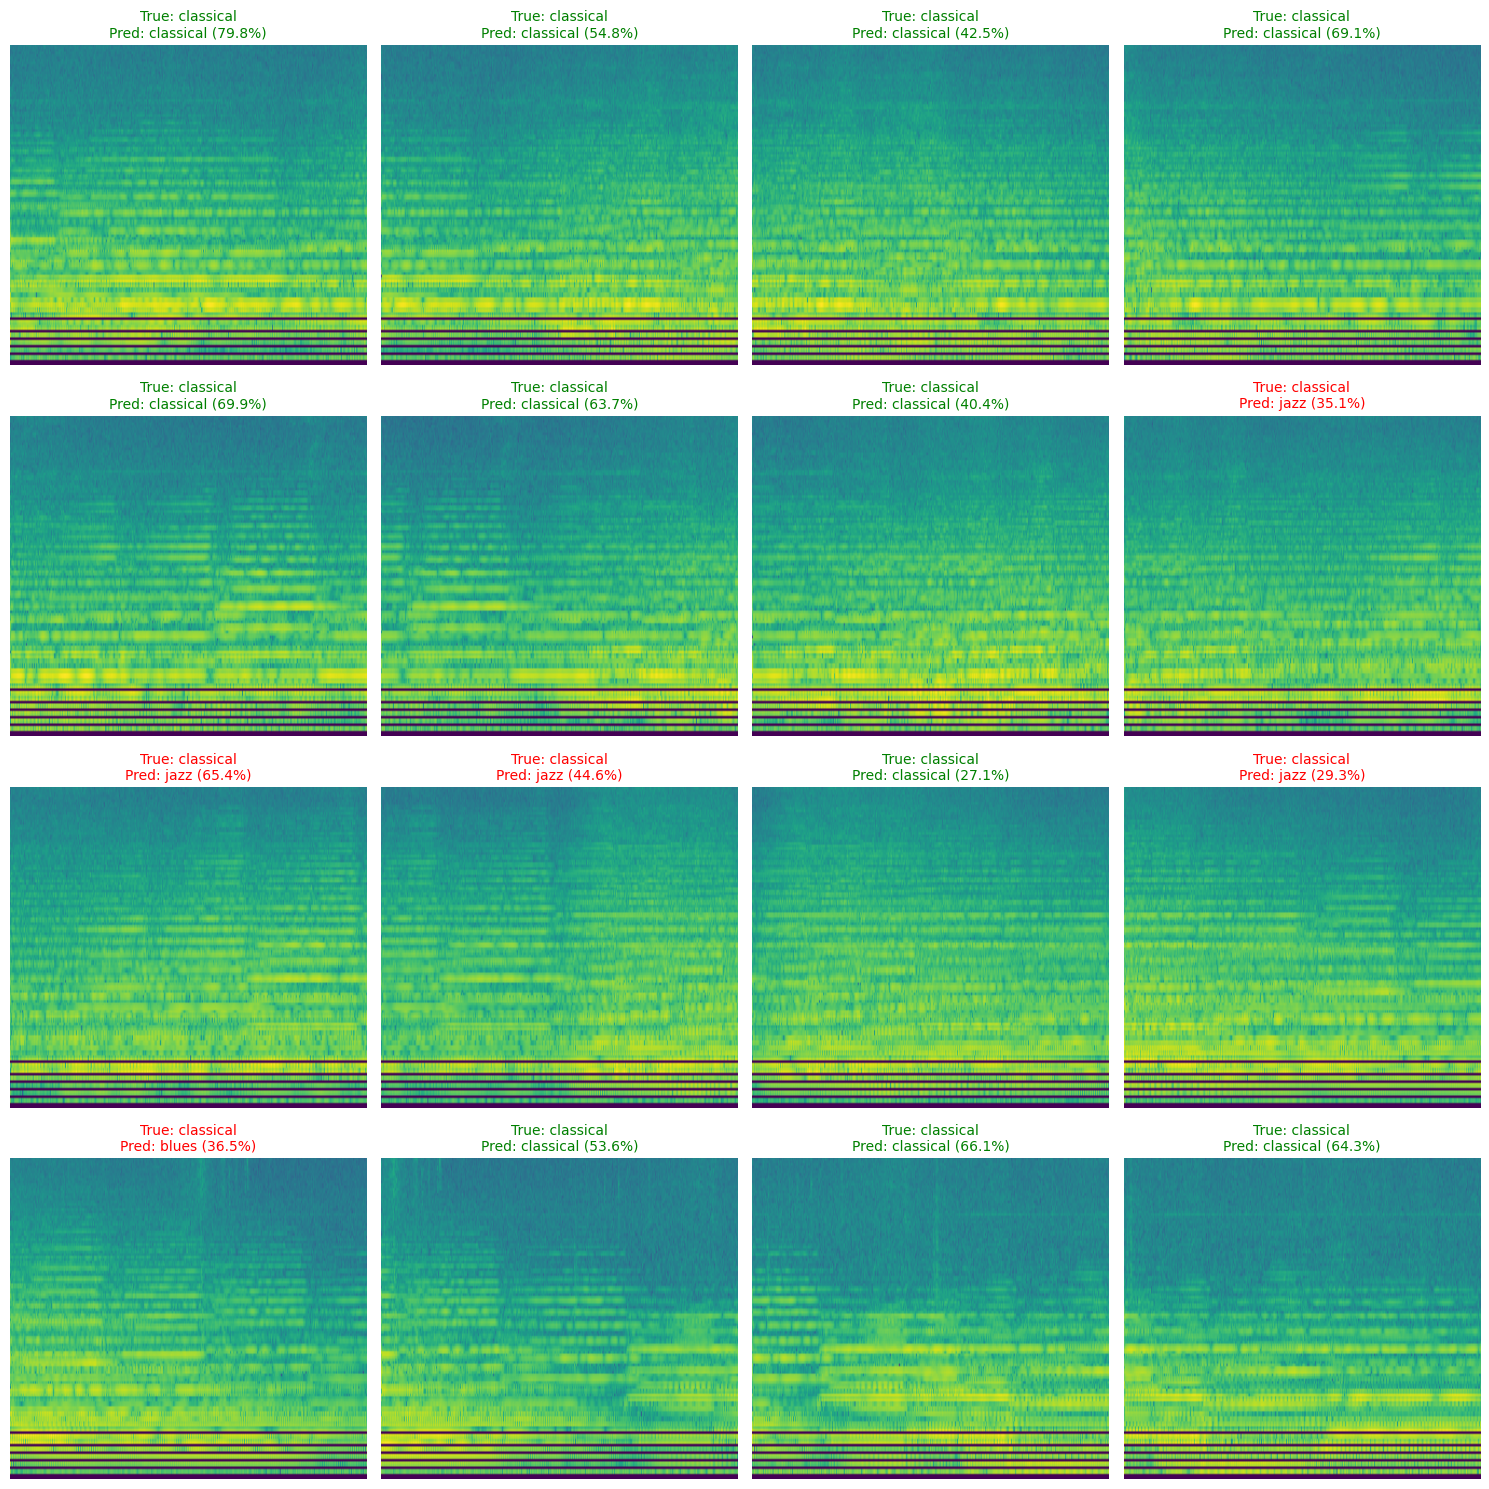

Computing confusion matrix...
Confusion matrix saved to ..\runs\20251127_172211\confusion_matrix.png


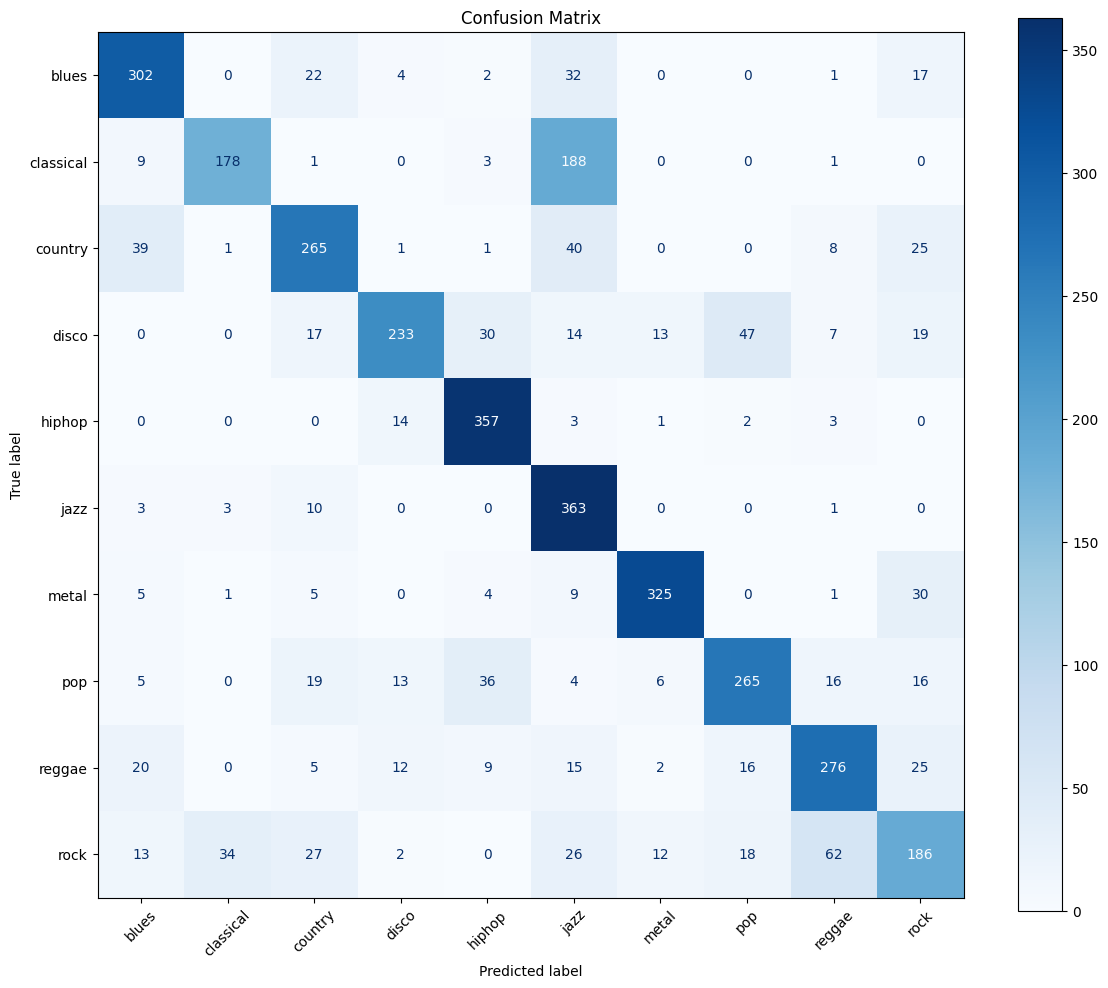

In [42]:
# GTZAN genre classification
import sys
from pathlib import Path
from datetime import datetime

repo_root = Path.cwd().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# Import model (prefer module; fallback to notebook)
try:
    from model_cnn import ImprovedCNN
except ModuleNotFoundError:
    print("Model module not found; loading from notebook via %run ...")
    %run "./04_model_cnn.ipynb"

# Import dataset utils
try:
    from utils.datasets_gtzan import GTZANDataset, create_dataloaders, GENRES
except ModuleNotFoundError:
    print("Dataset module not found; loading from notebook via %run ...")
    %run "./01_data_loading_gtzan.ipynb"

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GENRE_NAMES = ['blues', 'classical', 'country', 'disco', 'hiphop', 
               'jazz', 'metal', 'pop', 'reggae', 'rock']

# Update this to your latest run directory
run_dir = Path("../runs/20251127_172211/") 
model_path = run_dir / 'gtzan_cnn.pth'

if not model_path.exists():
    print(f"Warning: Model not found at {model_path}. Please check the path.")
else:
    # Load model
    model = load_trained_model(
        ImprovedCNN, 
        str(model_path), 
        n_classes=10, 
        device=device
    )

    # 1. Single File Prediction
    print("\n--- Single File Prediction ---")
    audio_path = '../data/gtzan/country/country.00001.wav'
    if Path(audio_path).exists():
        predicted_genre, confidence, probs = predict_genre(
            model, audio_path, GENRE_NAMES, device
        )
        visualize_prediction(audio_path, probs, GENRE_NAMES, save_path=str(run_dir / 'prediction_single.png'))
    else:
        print(f"Audio file not found: {audio_path}")

    # 2. Batch Visualization & Confusion Matrix
    print("\n--- Batch Evaluation ---")
    # Create validation dataloader
    gtzan_root = repo_root / "data" / "gtzan"
    if gtzan_root.exists():
        dataset = GTZANDataset(str(gtzan_root), cache_to_memory=False)
        
        # Use chunking for evaluation as well to match training
        _, val_loader = create_dataloaders(
            dataset, 
            batch_size=32, 
            chunk_length_sec=3.0
        )
        
        # Visualize Batch Predictions
        print("Visualizing batch predictions...")
        visualize_batch_predictions(
            model, val_loader, GENRE_NAMES, device, 
            num_samples=16, 
            save_path=str(run_dir / 'prediction_batch.png')
        )
        
        # Plot Confusion Matrix
        plot_confusion_matrix(
            model, val_loader, GENRE_NAMES, device, 
            save_path=str(run_dir / 'confusion_matrix.png')
        )
    else:
        print(f"Dataset root not found: {gtzan_root}")

### Music Tagging Example

In [9]:
# Example for MTAT music tagging
# Uncomment and adapt to your setup

# from notebooks.model_cnn import DeepCNN

# # Load model
# TAG_NAMES = ['rock', 'pop', 'alternative', 'indie', ...]  # Your tag list
# model = load_trained_model(
#     DeepCNN,
#     '../models/mtat_cnn.pth',
#     n_classes=50,
#     device=device
# )

# # Predict tags
# audio_path = '../data/test_audio.wav'
# predicted_tags, top_tags = predict_tags(
#     model, audio_path, TAG_NAMES, device, threshold=0.3, top_k=10
# )